# Curves frate
Plot average frate as a function of s relative to apex position for each curve and cell

In [36]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, curves, get_roi_crossings

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

# print all available recordings
print(get_recording_names())

['FC_220408_BAA1101192_hairpin' 'FC_220409_BAA1101192_hairpin'
 'FC_220410_BAA1101192_hairpin' 'FC_220411_BAA1101192_hairpin'
 'FC_220412_BAA1101192_hairpin' 'FC_220413_BAA1101192_hairpin'
 'FC_220414_BAA1101192_hairpin' 'FC_220415_BAA1101192_hairpin'
 'FC_220432_BAA1101192_hairpin' 'FC_220433_BAA1101192_hairpin'
 'FC_220434_BAA1101192_hairpin' 'FC_220435_BAA1101192_hairpin']


In [37]:
def frate(spikes, s, bins):
    """
        Given the s position at each frame at the frame at which spikes occurred during a ROI crossing,
        get firing rate wrt position relative to the apex.
    """
    # s = rolling_mean(s, 21)
    n_visits_per_bin, _ = np.histogram(s, bins=bins)

    spikes_positions = [s[spike] for spike in spikes]
    nspikes_per_bin = np.histogram(spikes_positions, bins=bins)[0]


    spikes_positions = rolling_mean(spikes_positions, 5)
    nspikes_per_bin = rolling_mean(nspikes_per_bin, 5)


    frates = nspikes_per_bin / n_visits_per_bin * 60
    frates[np.isnan(frates)] = 0.0
    frates[np.isinf(frates)] = 0.0  # a spike but no frame count?
    return frates

In [57]:
def plot_crossings(axes, crossings, curve, bouts, unit, frate_ax_id, raster_ax_id, color, yshift=0, sign=-1):
    bins = np.arange(-20, 20+4, step=2)
    bins_centers = (bins[1:] + bins[:-1]) / 2

    _frates = {b:[] for b in bins_centers}

    for n, cross in crossings.iterrows():
        s = sign * (curve.s - np.array(bouts.iloc[cross.bout_idx].s[cross.enter_frame:cross.exit_frame]))
        s = rolling_mean(s, 11)
        spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame
        axes[str(frate_ax_id)].plot(
            s[spikes],
            np.ones_like(spikes)*(n+yshift),
            ".",
            color=color
        )

        cross_frate = rolling_mean(frate(spikes, s, bins), 4)
        # cross_frate = frate(spikes, s, bins)
        for b, fr in zip(bins, cross_frate):
            _frates[b].append(fr)


    if len(crossings) > 5:
        frates = np.vstack(list(_frates.values())[:-1])
        mean_frate = np.mean(frates, 1)
        sem_frate = np.std(frates, 1) / np.sqrt(len(crossings))
        plot_mean_and_error(
            mean_frate[:-1], sem_frate[:-1], axes[str(raster_ax_id)], x=bins[:-2], color=color
        )


def plot_avg_speed_wrt_s(axes, crossings, bouts, curve, ax_id, color, sign=-1, angvel = False):
    bins = np.arange(-20, 20+2, step=2)
    speeds = {b:[] for b in bins}

    for n, cross in crossings.iterrows():
        bout = bouts.iloc[cross.bout_idx]
        s = sign * (curve.s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))
        s = np.round(s).astype(np.int64)
        # s = rolling_mean(s, 11)

        if angvel:
            speed = rolling_mean(bout.angvel[cross.enter_frame:cross.exit_frame], 11)
        else:
            speed = rolling_mean(bout.speed[cross.enter_frame:cross.exit_frame], 11)
        
        for (_s, S) in zip(s, speed):
            if _s in speeds.keys():
                speeds[_s].append(S)

    mean_speed = [np.mean(v) if len(v) else np.nan for v in speeds.values()]
    sem_speed = np.array([np.std(v) if len(v) else np.nan for v in speeds.values()]) / np.sqrt(len(crossings))

    plot_mean_and_error(
            mean_speed, sem_speed, axes[str(ax_id)], x=bins, color=color
        )


In [44]:
def make_figure(out_bouts, in_bouts, out_crossings, in_crossings, unit):
    fig = plt.figure(figsize=(30, 14))
    axes = fig.subplot_mosaic(
    """
        abcdefg
        hilmnop
        hilmnop
        qrstuvz
        qrstuvz
        1234567
        ABCDEFG
    """
    )

    speeds_axes = "1234567"
    avel_axes = "ABCDEFG"
    xy_axes = "abcdefg"
    avg_frate_axes="hilmnopq"
    raster_axes="qrstuvz"

    x_shift = [15, 5, 22, 5, 15, 5, 5, ]
    y_shift = [0, 0, 0, 0, 0, 0, 10,]

    for i, curve in enumerate(curves.keys()):
        crossings_out = out_crossings[curve]
        crossings_in = in_crossings[curve]
        axes[xy_axes[i]].set(title=curve)
        curve = curves[curve]


        plot_crossings(axes, crossings_out, curve, out_bouts, unit,raster_axes[i], avg_frate_axes[i], "k", yshift=0, sign=-1)
        plot_crossings(axes, crossings_in, curve, in_bouts, unit,raster_axes[i], avg_frate_axes[i], "r", yshift=len(crossings_out), sign=-1)

        plot_avg_speed_wrt_s(axes, crossings_out, out_bouts, curve, speeds_axes[i], "k", sign=-1)
        plot_avg_speed_wrt_s(axes, crossings_in, in_bouts, curve, speeds_axes[i], "r", sign=-1)
        plot_avg_speed_wrt_s(axes, crossings_out, out_bouts, curve,  avel_axes[i], "k", sign=-1, angvel=True)
        plot_avg_speed_wrt_s(axes, crossings_in, in_bouts, curve, avel_axes[i], "r", sign=-1, angvel=True)

        for n, cross in crossings_out.iterrows():
            bout = out_bouts.iloc[cross.bout_idx]
            axes[xy_axes[i]].scatter(
                (np.array(bout.x[cross.enter_frame:cross.exit_frame]) - x_shift[i]),
                (np.array(bout.y[cross.enter_frame:cross.exit_frame]) - y_shift[i]),
                c=np.arange(cross.exit_frame - cross.enter_frame), cmap="Greys", s=5, vmin=-5, vmax=80
            )

        for n,  cross in crossings_in.iterrows():
            bout = in_bouts.iloc[cross.bout_idx]
            axes[xy_axes[i]].scatter(
                np.array(bout.x[cross.enter_frame:cross.exit_frame]),
                np.array(bout.y[cross.enter_frame:cross.exit_frame]),
                c=np.arange(cross.exit_frame - cross.enter_frame), cmap="Reds", s=5, vmin=-5, vmax=80
            )


    for i, ax in enumerate(avg_frate_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[],  ylabel="frate (Hz)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)

    for i, ax in enumerate(raster_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[], ylabel="crossing #" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)

    for i, ax in enumerate(speeds_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[], ylim=[10, 80], ylabel="speed (cm/s)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)
        if i > 0:
            axes[ax].sharey(axes[speeds_axes[0]])
            axes[ax].set(yticks=[])

    axes[speeds_axes[0]].set(ylabel="speed (cm/s)", yticks=[20, 40, 60, 80])


    for i, ax in enumerate(avel_axes):
        axes[ax].set(xlim=[-20, 20], xlabel="delta S (cm)", ylim=[-6, 6], ylabel="ang. vel. (def/s)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)
        
        

    for i, ax in enumerate(xy_axes):
        axes[ax].axis("equal")
        axes[ax].axis("off")

    clean_axes(fig)
    fig.suptitle(f"{unit.unit_id} - {unit.brain_region}")
    return fig

make a single fig for debugging

In [40]:
REC = "FC_220408_BAA1101192_hairpin"

units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
out_bouts = get_session_bouts(REC, complete=None)
in_bouts = get_session_bouts(REC, direction="inbound", complete=None)

out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

[06/09/22 11:35:01] INFO     Got tracking data for FC_220408_BAA1101192_hairpin  ]8;id=301488;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=741185;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 44 units for FC_220408_BAA1101192_hairpin       ]8;id=437589;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=281679;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 11:35:02] INFO     Got 41 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=795492;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=659689;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

                    INFO     Got 40 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=182275;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=669105;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

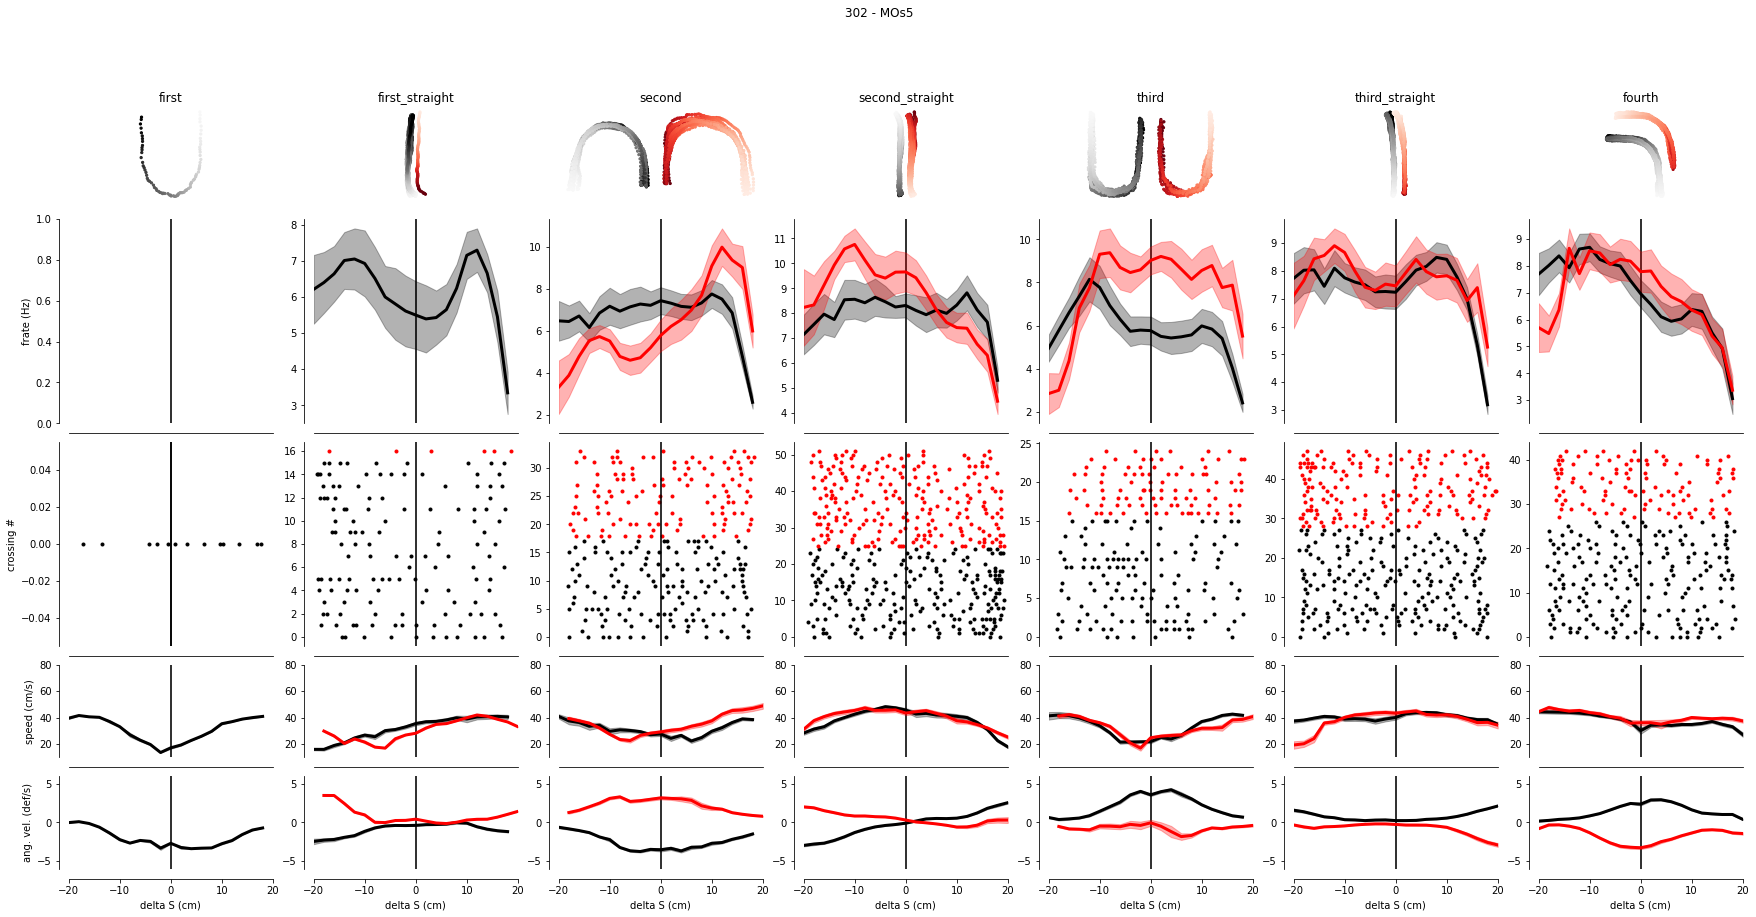

In [58]:
f = make_figure(out_bouts, in_bouts, out_crossings, in_crossings, units.iloc[10])
plt.show(f)

plot all sessions/units

In [59]:
for REC in get_recording_names():
    dest = save_folder / REC / "curves_rasters"
    if dest.exists():
        for f in dest.glob("*"):
            f.unlink()
        dest.rmdir()
    dest.mkdir(exist_ok=True, parents=True)

    units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    if units is None:
        continue

    out_bouts = get_session_bouts(REC, complete=None)
    in_bouts = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

    for (i, unit) in units.iterrows():
        region = unit.brain_region[:3]
        savepath= dest / f"{region}_{unit.unit_id}.png"
        # if savepath.exists():
        #     continue

        fig = make_figure(out_bouts, in_bouts, out_crossings, in_crossings, unit)
        fig.savefig(savepath, dpi=150, transparent=False, facecolor='w', edgecolor='w')

        # close figure 
        plt.close(fig)
    #     break
    # break
        

[06/09/22 11:43:00] INFO     Got tracking data for FC_220408_BAA1101192_hairpin  ]8;id=431281;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=134247;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 11:43:01] INFO     Got 44 units for FC_220408_BAA1101192_hairpin       ]8;id=15338;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=168339;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 11:43:02] INFO     Got 41 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=567599;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=648553;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

                    INFO     Got 40 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=928853;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=509747;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 11:48:02] INFO     Got tracking data for FC_220409_BAA1101192_hairpin  ]8;id=768956;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=421194;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 44 units for FC_220409_BAA1101192_hairpin       ]8;id=458202;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=931894;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 11:48:03] INFO     Got 48 bouts for FC_220409_BAA1101192_hairpin |     ]8;id=120121;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=753346;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 11:48:04] INFO     Got 49 bouts for FC_220409_BAA1101192_hairpin |     ]8;id=965640;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=96896;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 11:56:35] INFO     Got tracking data for FC_220410_BAA1101192_hairpin  ]8;id=590598;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=374283;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 40 units for FC_220410_BAA1101192_hairpin       ]8;id=105171;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=332478;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 11:56:36] INFO     Got 76 bouts for FC_220410_BAA1101192_hairpin |     ]8;id=416288;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=531956;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 11:56:37] INFO     Got 65 bouts for FC_220410_BAA1101192_hairpin |     ]8;id=397013;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=887979;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:02:18] INFO     Got tracking data for FC_220411_BAA1101192_hairpin  ]8;id=534115;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=251991;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 40 units for FC_220411_BAA1101192_hairpin       ]8;id=693967;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=440737;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:02:19] INFO     Got 45 bouts for FC_220411_BAA1101192_hairpin |     ]8;id=105644;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=85674;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:02:20] INFO     Got 35 bouts for FC_220411_BAA1101192_hairpin |     ]8;id=321193;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=454839;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:05:33] INFO     Got tracking data for FC_220412_BAA1101192_hairpin  ]8;id=977140;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=795785;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 42 units for FC_220412_BAA1101192_hairpin       ]8;id=281072;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=993528;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:05:34] INFO     Got 57 bouts for FC_220412_BAA1101192_hairpin |     ]8;id=597403;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=497695;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:05:35] INFO     Got 55 bouts for FC_220412_BAA1101192_hairpin |     ]8;id=285260;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=318427;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:10:19] INFO     Got tracking data for FC_220413_BAA1101192_hairpin  ]8;id=422656;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=748470;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 12:10:20] INFO     Got 55 units for FC_220413_BAA1101192_hairpin       ]8;id=421599;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=777379;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:10:21] INFO     Got 84 bouts for FC_220413_BAA1101192_hairpin |     ]8;id=232146;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=263595;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:10:22] INFO     Got 86 bouts for FC_220413_BAA1101192_hairpin |     ]8;id=798952;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=974814;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:19:03] INFO     Got tracking data for FC_220414_BAA1101192_hairpin  ]8;id=408323;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=15311;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 56 units for FC_220414_BAA1101192_hairpin       ]8;id=906028;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=941752;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:19:04] INFO     Got 65 bouts for FC_220414_BAA1101192_hairpin |     ]8;id=15214;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=507054;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:19:05] INFO     Got 64 bouts for FC_220414_BAA1101192_hairpin |     ]8;id=193814;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=997300;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:28:34] INFO     Got tracking data for FC_220415_BAA1101192_hairpin  ]8;id=546366;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=961250;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 52 units for FC_220415_BAA1101192_hairpin       ]8;id=775956;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=87925;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:28:35] INFO     Got 62 bouts for FC_220415_BAA1101192_hairpin |     ]8;id=869053;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=447091;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:28:37] INFO     Got 68 bouts for FC_220415_BAA1101192_hairpin |     ]8;id=929238;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=448486;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:39:14] INFO     Got tracking data for FC_220432_BAA1101192_hairpin  ]8;id=846209;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=870246;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 12:39:15] INFO     Got 40 units for FC_220432_BAA1101192_hairpin       ]8;id=693853;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=893634;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:39:16] INFO     Got 64 bouts for FC_220432_BAA1101192_hairpin |     ]8;id=158417;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=543358;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:39:17] INFO     Got 61 bouts for FC_220432_BAA1101192_hairpin |     ]8;id=766438;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=818173;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:46:35] INFO     Got tracking data for FC_220433_BAA1101192_hairpin  ]8;id=770476;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=673006;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 47 units for FC_220433_BAA1101192_hairpin       ]8;id=757027;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=731929;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:46:38] INFO     Got 110 bouts for FC_220433_BAA1101192_hairpin |    ]8;id=805469;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=497005;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:46:40] INFO     Got 120 bouts for FC_220433_BAA1101192_hairpin |    ]8;id=592914;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=650833;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 12:59:01] INFO     Got tracking data for FC_220434_BAA1101192_hairpin  ]8;id=629127;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=293232;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 12:59:02] INFO     Got 74 units for FC_220434_BAA1101192_hairpin       ]8;id=704684;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=488696;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 12:59:05] INFO     Got 87 bouts for FC_220434_BAA1101192_hairpin |     ]8;id=882982;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=835239;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 12:59:07] INFO     Got 89 bouts for FC_220434_BAA1101192_hairpin |     ]8;id=228145;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=692661;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 13:18:41] INFO     Got tracking data for FC_220435_BAA1101192_hairpin  ]8;id=576179;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=703744;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 13:18:42] INFO     Got 56 units for FC_220435_BAA1101192_hairpin       ]8;id=944627;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=322108;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 13:18:43] INFO     Got 68 bouts for FC_220435_BAA1101192_hairpin |     ]8;id=568151;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=410456;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 13:18:44] INFO     Got 66 bouts for FC_220435_BAA1101192_hairpin |     ]8;id=386321;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=913462;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound